In [1]:
import os
import math

from kneed import KneeLocator

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (silhouette_score, adjusted_rand_score)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
WORKDIR = os.path.abspath(os.getcwd())

YEARS_AVAILABLE = [2014, 2018, 2021]

## Get the data

__Load into Pandas DataFrame__

In [3]:
file = ''.join([WORKDIR, "/data/output/hotspot_spi.csv"]) 
dataset = pd.read_csv(file)

dataset

,ano,estado,municipio,diasemchuva,precipitacao,riscofogo,frp,fococalor,riscofogocat,IPS Amazônia,...,Gravidez na infância e adolescência,Trabalho Infantil,Vulnerabilidade familiar,Violência contra indígenas,Violência contra indígenas Taxa,Violência contra mulheres,Violência infantil,Violência infantil Taxa,Empregos ensino superior,Mulheres com empregos ensino superior
0,2014,ACRE,ACRELANDIA,0.9,0.38,0.23,0.00,441,BAIXO,54.64,...,26.77,288.91,12.27,0.00,1.0,29.60,22.32,2.0,13.81,7.35
1,2014,ACRE,ASSIS BRASIL,1.7,0.46,0.15,0.00,327,BAIXO,53.48,...,36.22,201.25,17.35,1.88,2.0,58.91,80.48,3.0,8.17,4.54
2,2014,ACRE,BRASILEIA,1.4,0.36,0.19,0.00,1120,BAIXO,50.05,...,31.08,144.83,20.11,40.00,5.0,300.00,683.19,5.0,9.97,6.59
3,2014,ACRE,BUJARI,0.8,0.36,0.12,0.00,339,BAIXO,54.02,...,34.30,824.47,16.12,0.00,1.0,45.11,32.66,2.0,12.97,9.16
4,2014,ACRE,CAPIXABA,0.8,0.10,0.08,0.00,455,BAIXO,53.15,...,32.05,172.42,26.07,0.00,1.0,0.00,0.00,1.0,11.60,7.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,2021,TOCANTINS,TOCANTINOPOLIS,23.2,0.32,0.85,9.03,799,ALTO,53.76,...,25.06,19.09,58.55,16.50,4.0,632.00,433.17,5.0,15.30,11.06
2312,2021,TOCANTINS,TUPIRAMA,39.5,0.94,0.81,7.53,180,ALTO,53.14,...,30.77,9.64,53.85,0.00,1.0,148.61,141.85,4.0,20.10,14.28
2313,2021,TOCANTINS,TUPIRATINS,43.5,0.41,0.89,9.99,690,ALTO,60.37,...,32.14,3.05,28.57,0.00,1.0,159.21,0.00,1.0,19.09,15.72
2314,2021,TOCANTINS,WANDERLANDIA,17.7,0.42,0.80,4.85,622,ALTO,54.31,...,27.59,11.80,81.03,0.00,1.0,0.00,24.26,2.0,15.15,12.15


In [4]:
le = LabelEncoder()

dataset["estado"] = le.fit_transform(dataset["estado"])
dataset["municipio"] = le.fit_transform(dataset["municipio"])

## Functions

#### The Elbow Method

In [5]:
def peform_elbow_method(kmeans_kwargs, n_inter, features):
    sse = []
    min_cluster = 1
    
    for k in range(min_cluster, n_inter):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
    
    show_elbow_method(sse, n_inter, min_cluster)

        
def show_elbow_method(sse, n_inter, min_cluster):
    kl = KneeLocator(
        range(1, n_inter), 
        sse, 
        curve="convex", 
        direction="decreasing")
    
    plt.plot(range(1, n_inter), sse)
    
    plt.xticks(range(1, n_inter))
    plt.xlabel("Number of Clusters")
    plt.axvline(kl.elbow, c='tab:gray', ls='--')
    
    plt.ylabel("SSE")
    plt.show()

#### The Silhouette Coefficients

In [6]:
def peform_silhouette_coefficients(kmeans_kwargs, n_inter, features):
    #The silhouette score() function needs a minimum of two clusters, or it will raise an exception.
    min_cluster = 2
    sicoefs = []
    
    for k in range(min_cluster, n_inter):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        sicoefs.append(score)
        
    show_silhouette_coefficients(sicoefs, n_inter, min_cluster)

def show_silhouette_coefficients(sicoefs, n_inter, min_cluster):
    plt.plot(range(min_cluster, n_inter), sicoefs)
    plt.xticks(range(min_cluster, n_inter))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

#### Ajusted Rand Index

In [7]:
def perform_ari(true_labels, predicted_label):
    ari = adjusted_rand_score(true_labels, predicted_label)
    return round(ari, 2)

In [18]:
def xyz(features, true_labels, n_cluster=10, n_cluster_val=11):
    print("===========================================================")
    print("Features:\n", features[:5])
    print("True Labels:\n", true_labels[:5])
    print("===========================================================")
    
    
    # Standarization
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    print("Scaled Features:\n", scaled_features[:5])
    print("===========================================================")
    
    
    # Create KMeans Model
    kmeans = KMeans(n_clusters=n_cluster)
    _ = kmeans.fit(scaled_features)
    
    
    # show data points clusters
    y_pred = kmeans.fit_predict(scaled_features)
    plt.figure(figsize=(10, 10))
    plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=y_pred)
    plt.show()
    
    
    # Statistics from the initialization
    print("===========================================================")
    # The lowest SSE value
    print("Lowest SSE Value:", kmeans.inertia_)

    # The number of iterations required to converge
    print("Iterations Required to Converge:", kmeans.n_iter_)

    # Final locations of the centroid
    print("Final locations of the centroid:\n", kmeans.cluster_centers_)
    print("===========================================================")
    
        
    # Choosing the Appropriate Number of Clusters
    kmeans_kwargs = kmeans.get_params()
    del kmeans_kwargs['n_clusters']
    
    peform_elbow_method(kmeans_kwargs, n_cluster_val, scaled_features)
    peform_silhouette_coefficients(kmeans_kwargs, n_cluster_val, scaled_features)
    
    
    # Ajusted Rand Index
    print("===========================================================")
    print("Ajusted Rand Index:\n", perform_ari(true_labels, kmeans.labels_))
    print("===========================================================")
    
    return kmeans.labels_

## Model Params

In [9]:
YEAR = 2018
N_CLUSTER = 3

## 1º Study Case - Only the dimensions

Features:
 [[63.41 52.44 41.28]
 [66.74 57.98 39.32]
 [67.3  62.61 23.07]
 [60.64 50.64 50.93]
 [60.12 53.51 40.98]]
True Labels:
 ['ALTO' 'MODERADO' 'MODERADO' 'MODERADO' 'MODERADO']
Scaled Features:
 [[-0.02642865 -0.30655314 -0.86812976]
 [ 0.4496538   0.71384642 -1.21216036]
 [ 0.52971572  1.56663521 -4.06445485]
 [-0.4224492  -0.6380909   0.82569435]
 [-0.4967924  -0.10947236 -0.92078751]]


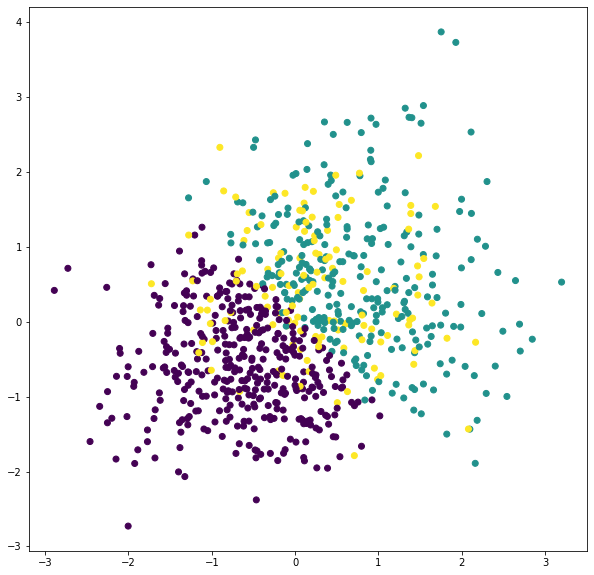

Lowest SSE Value: 1269.8782342851002
Iterations Required to Converge: 11
Final locations of the centroid:
 [[-0.65878136 -0.60734993  0.1828346 ]
 [ 0.78457005  0.62578718  0.53086242]
 [ 0.23609579  0.42567909 -1.66216467]]


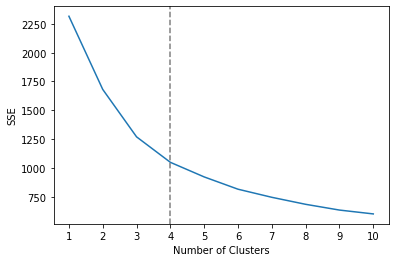

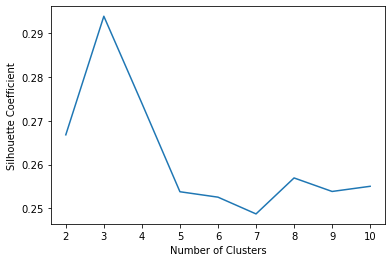

Ajusted Rand Index:
 0.05


array([2, 2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2,
       2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 2, 0, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2,
       0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 1,
       2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 2, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0,
       0, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1,

In [19]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Necessidades Humanas Básicas",
    "Fundamentos para o Bem-Estar",
    "Oportunidades"
]].values
xyz(features, true_labels, n_cluster=N_CLUSTER)

## 2º Study Case - "Necessidades Humanas Básicas" Components

Features:
 [[92.37 41.12 86.09 34.06]
 [90.48 54.53 69.15 52.79]
 [91.   56.7  79.41 42.11]
 [92.54 42.45 71.32 36.24]
 [91.36 31.36 82.84 34.91]]
True Labels:
 ['ALTO' 'MODERADO' 'MODERADO' 'MODERADO' 'MODERADO']
Scaled Features:
 [[ 0.66145409  0.11709131  0.50301432 -0.65827142]
 [ 0.31156197  0.95687802 -0.73469894  0.28540484]
 [ 0.40782859  1.09277191  0.01494321 -0.25268712]
 [ 0.69292587  0.20038112 -0.5761489  -0.54843617]
 [ 0.4744747  -0.49411811  0.26555458 -0.61544575]]


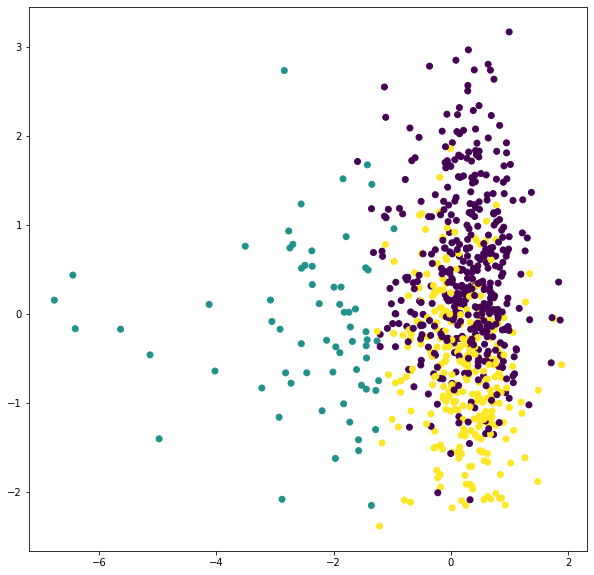

Lowest SSE Value: 2007.0946534588695
Iterations Required to Converge: 13
Final locations of the centroid:
 [[ 0.25518284  0.42937099  0.4653474  -0.47824593]
 [-2.44452581 -0.14511596  0.06458348  0.46955899]
 [ 0.19760901 -0.61699965 -0.72178479  0.61355025]]


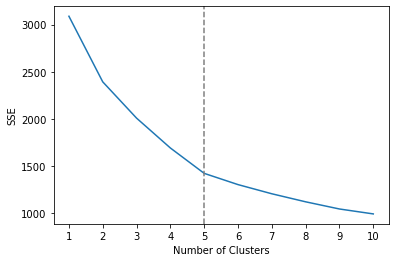

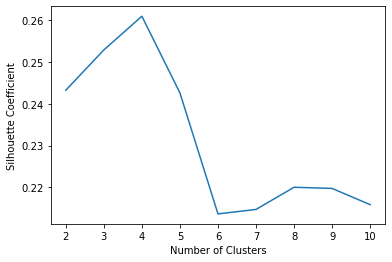

Ajusted Rand Index:
 -0.02


In [11]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Nutrição e cuidados médicos básicos",
    "Água e saneamento",
    "Moradia",
    "Segurança pessoal"
]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)

## 3º Study Case - "Oportunidades" Components

Features:
 [[27.52 64.41 65.09  8.11]
 [19.61 72.32 58.19  7.17]
 [16.56 66.46  0.    9.27]
 [28.57 63.27 98.39 13.5 ]
 [35.82 64.91 56.66  6.51]]
True Labels:
 ['ALTO' 'MODERADO' 'MODERADO' 'MODERADO' 'MODERADO']
Scaled Features:
 [[-0.01548769  0.11381718 -0.81503813 -0.38104072]
 [-1.31335907  1.16931911 -1.14023848 -0.49164484]
 [-1.81380252  0.38736699 -3.88276149 -0.24455052]
 [ 0.15679612 -0.0383032   0.75440707  0.25316804]
 [ 1.34637482  0.18053665 -1.21234813 -0.56930306]]


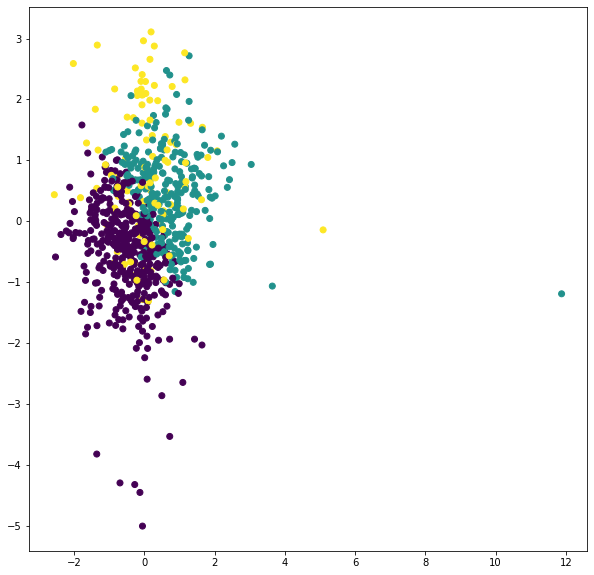

Lowest SSE Value: 1990.4136331250031
Iterations Required to Converge: 10
Final locations of the centroid:
 [[-0.49590266 -0.53056176  0.30702598 -0.35909654]
 [ 0.69700017  0.44150577  0.3146379   0.17473263]
 [ 0.07679143  0.87485532 -1.99188637  0.91546906]]


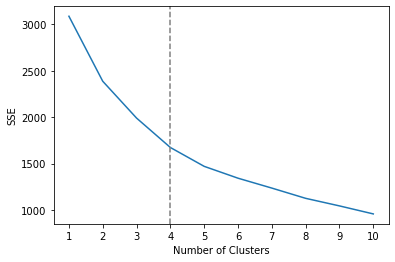

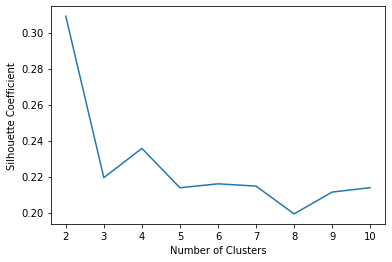

Ajusted Rand Index:
 0.03


In [12]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Direitos individuais",
    "Liberdade individual e de escolha",
    "Tolerância e inclusão",
    "Acesso à educação superior"
]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)

## 4º Study Case - "Necessidades Humanas Básicas" Indicators

Features:
 [[19.53  0.    6.66  6.66  3.64 31.41 82.3  36.21 51.62 96.03 95.31 92.1
  48.98  6.   28.68  5.   22.12]
 [16.13  0.   13.48 13.48  3.61 35.84 63.95 72.14 37.96 61.22 83.99 82.73
  69.65  6.    9.06  3.    4.49]
 [19.3   1.75  7.61  7.74  4.31 47.26 72.65 61.26 54.71 79.84 89.94 85.72
  33.21  5.   21.73  5.   11.52]
 [ 6.51  4.08  9.89  9.74  3.35 37.48 57.66 42.22 45.   78.5  77.86 76.7
  62.44  6.   39.26  5.    9.84]
 [20.58  0.    0.   25.57  2.18 33.93 12.02 35.94 38.68 87.59 96.17 95.78
  64.2   6.   34.57  5.   17.32]]
True Labels:
 ['ALTO' 'MODERADO' 'MODERADO' 'MODERADO' 'MODERADO']
Scaled Features:
 [[-0.05351644 -0.47211043  0.05821303 -0.71040014 -0.92605631 -1.1797335
   1.88589583 -0.67245802 -0.45289009  0.70725927  0.77331944  0.59724773
   0.08643311  0.72737084  0.19397926  0.52384349 -0.01610351]
 [-0.33284187 -0.47211043  0.73873593 -0.286026   -0.95070007 -1.00075918
   1.20016886  0.64100457 -1.09645613 -1.59240518  0.0803696  -0.00251725
   0.6136591

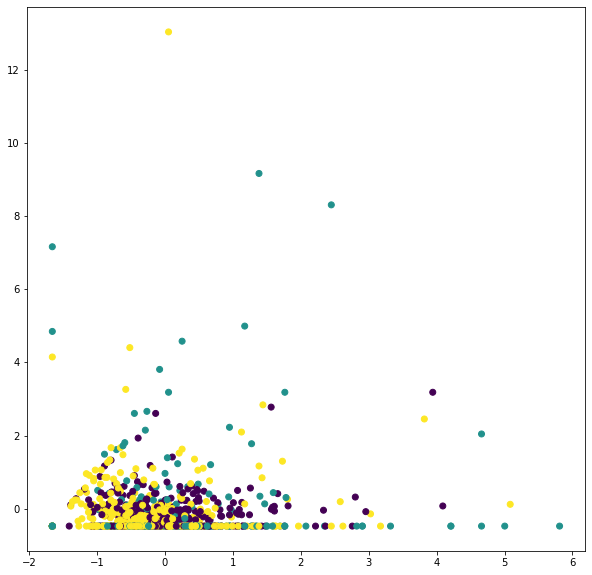

Lowest SSE Value: 10194.991346470575
Iterations Required to Converge: 20
Final locations of the centroid:
 [[ 0.07421025 -0.05312912 -0.11172846 -0.12201916  0.13113895 -0.70287265
  -0.08600285 -0.7339634  -0.90758643 -0.77865938 -0.77005668 -0.83824762
  -0.21543085  0.10157548 -0.27262015 -0.16294098 -0.3840073 ]
 [ 0.25980396  0.16678746  0.08477032  0.08801746 -0.09203972  0.30500201
   0.00173057  0.20546532  0.16001989  0.40388432  0.35648286  0.3659837
  -0.91004955 -1.31103193 -0.77928755 -0.99629531 -0.05370601]
 [-0.19161651 -0.0449683   0.04276288  0.04905627 -0.0540426   0.38688253
   0.06571402  0.46235454  0.62028664  0.39452293  0.41233465  0.46024173
   0.63672425  0.59824438  0.61350116  0.64060232  0.32513576]]


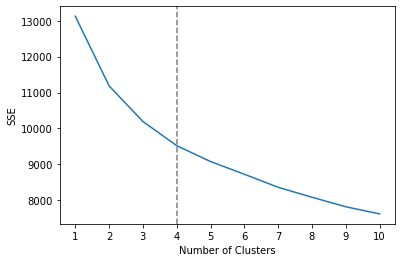

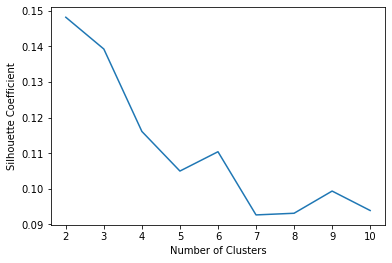

Ajusted Rand Index:
 -0.0


In [16]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Mortalidade infantil até 5 anos",
    "Mortalidade materna",
    "Mortalidade por desnutrição",
    "Mortalidade por doenças infecciosas",
    "Subnutrição",
    
    "Abastecimento de água",
    "Esgotamento sanitário",
    "Índice de atendimento de agua",
    
    "Coleta de lixo",
    "Moradias com iluminação adequada",
    "Moradias com parede adequada",
    "Moradias com piso adequado",
    
    "Assassinatos de jovens",
    "Assassinatos de jovens Taxa",
    "Homicídios",
    "Homicídios Taxa",
    "Mortes por acidente no trânsito",

]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)

### 4º Study Case - "Fundamentos para o Bem-Estar" Indicators

Features:
 [[  2.    26.3   41.3    4.95   8.1   11.89   8.44  55.83   4.04  32.77
   65.55 111.43  58.99   6.66   0.    62.97   3.86  97.57  10.72]
 [  5.9   47.    40.9    4.2   14.3   15.16  17.4   47.77   5.4   13.48
   26.97 121.34  53.93  13.7   84.08   5.54   5.52  89.5   26.03]
 [  1.2   21.1   23.9    6.1    4.6   17.48  19.68  66.89   7.45  34.25
   64.69 137.    49.47   7.08  49.14  35.     4.58  77.38  19.58]
 [  4.7   32.5   41.2    4.15   5.5    8.13   9.35  36.47   7.07   9.74
   68.19  77.93  68.19  19.48  11.25  40.66   2.78 114.26  21.66]
 [  4.1   33.    27.2    4.3   10.8    9.45  10.81  44.16   3.9   34.09
   25.57  25.57  17.05   9.87   3.16  51.98   3.82  98.33  17.89]]
True Labels:
 ['ALTO' 'MODERADO' 'MODERADO' 'MODERADO' 'MODERADO']
Scaled Features:
 [[-2.76401033e-01  3.00751650e-01  1.89842573e-01  7.66804226e-01
  -4.76735724e-02  2.63346285e-01 -3.28405466e-02  6.64129967e-02
  -5.00497625e-01 -1.00800210e-02  2.34818019e-01 -2.85771253e-01
   5.68952045e-

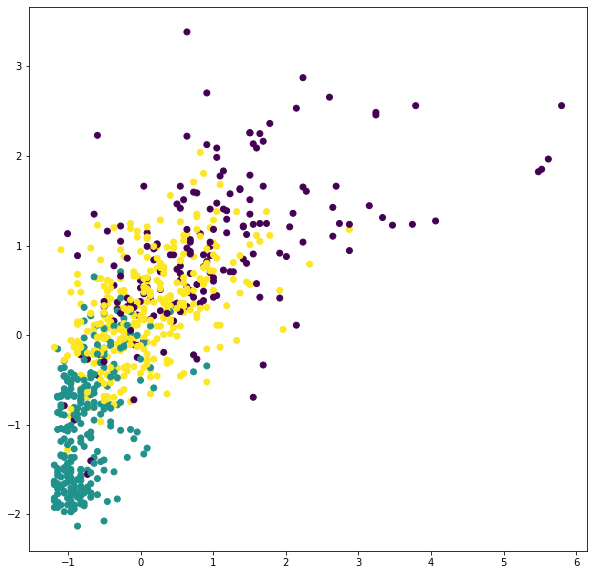

Lowest SSE Value: 10645.792935844238
Iterations Required to Converge: 20
Final locations of the centroid:
 [[ 0.94778231  0.92716591  0.73857583 -0.53402565  0.58312301 -0.47660288
  -0.52169507 -0.59205395  0.05538649 -0.67057487 -0.65294158 -0.87613067
  -0.40597661 -0.20736662  1.12848935 -0.60716266  0.70419465  0.43065537
   0.38988707]
 [-0.74810047 -0.98387056 -0.85497778  0.98726385 -0.82616077  0.83675487
   0.94638873  0.8390339   0.41858609  0.24771116  0.55681486  0.27059642
   0.46008651  0.25904469 -0.22387811 -0.12300723 -0.11283578  0.20795692
   0.06473428]
 [ 0.06649408  0.26560626  0.26826166 -0.48764991  0.33206235 -0.39992284
  -0.46200385 -0.33732309 -0.36398383  0.17702009 -0.07878161  0.27349466
  -0.13960018 -0.09043467 -0.45146757  0.43663309 -0.30310208 -0.4057521
  -0.26903958]]


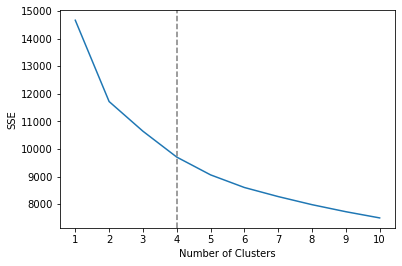

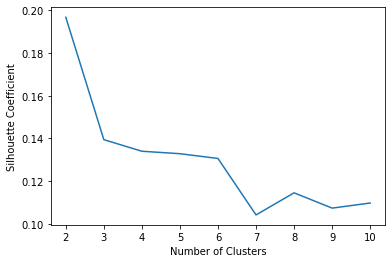

Ajusted Rand Index:
 0.1


In [17]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Abandono escolar ensino fundamental",
    "Distorção idade-série ensino fundamental",
    "Distorção idade-série ensino médio",
    "Qualidade da educação Ideb ensino fundamental",
    "Reprovação escolar ensino fundamental",
    
    "Densidade internet banda-larga",
    "Densidade telefonia fixa",
    "Densidade telefonia movel",
    "Densidade TV por assinatura",
    
    "Mortalidade por diabetes mellitus",
    "Mortalidade por câncer",
    "Mortalidade por doenças circulatórias",
    "Mortalidade por doenças respiratórias",
    "Mortalidade por suicídios",

    "Áreas Protegidas",
    "Desmatamento acumulado",
    "Desmatamento recente",
    "Emissões CO2",
    "Focos de calor por habitantes"
]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)

### 4º Study Case - "Oportunidades" Indicators

Features:
 [[6.6670e+01 3.4000e+00 1.0000e+00 2.5390e+01 7.1710e+01 1.5230e+01
  0.0000e+00 1.0000e+00 1.4210e+02 1.2276e+02 3.0000e+00 1.3090e+01
  7.2400e+00]
 [5.5560e+01 6.8000e-01 5.0000e+00 2.6610e+01 1.9080e+01 1.6940e+01
  1.8800e+00 2.0000e+00 1.4034e+02 5.3450e+01 3.0000e+00 1.1020e+01
  6.7300e+00]
 [4.5450e+01 8.9000e-01 3.0000e+00 2.8420e+01 3.9710e+01 2.1230e+01
  4.0000e+01 5.0000e+00 3.0000e+02 7.8917e+02 5.0000e+00 1.4330e+01
  8.6400e+00]
 [7.7780e+01 1.6800e+00 3.0000e+00 3.0940e+01 2.1833e+02 1.4330e+01
  0.0000e+00 1.0000e+00 1.4180e+01 3.2660e+01 1.0000e+00 1.9760e+01
  1.3250e+01]
 [1.0000e+02 1.5700e+00 3.0000e+00 2.9220e+01 1.2220e+02 2.0580e+01
  2.5000e+02 5.0000e+00 4.8990e+01 1.9660e+01 2.0000e+00 9.7000e+00
  6.2900e+00]]
True Labels:
 ['ALTO' 'MODERADO' 'MODERADO' 'MODERADO' 'MODERADO']
Scaled Features:
 [[-0.30689441  0.3214695  -0.89855314 -0.08123254 -0.27005649 -1.21358025
  -0.16898977 -0.41241837  1.06410643  0.50451593  1.16873418 -0.27954141
  -0.

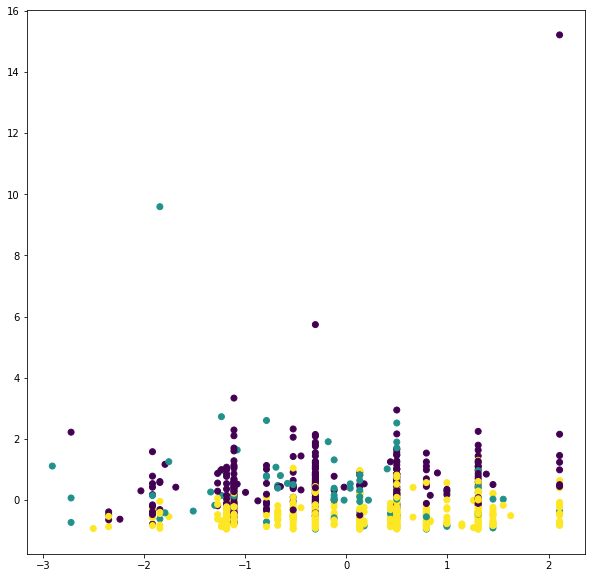

Lowest SSE Value: 7572.817751056249
Iterations Required to Converge: 18
Final locations of the centroid:
 [[-0.28274936  0.60939709 -0.01903869 -0.78765673 -0.23224286 -0.40736289
  -0.16044768 -0.32243433 -0.17998351 -0.14205608 -0.20649478  0.26285379
   0.28994631]
 [-0.17083051  0.35259221  1.28556553 -0.42606651 -0.19691086 -0.19743471
   1.20294656  1.99298598  1.91648931  1.42068092  1.64843221  1.02422924
   0.92871829]
 [ 0.20617196 -0.44124961 -0.24431619  0.56441781  0.18061022  0.28734497
  -0.14176595 -0.20040019 -0.27191072 -0.19630749 -0.20240772 -0.36393787
  -0.36142177]]


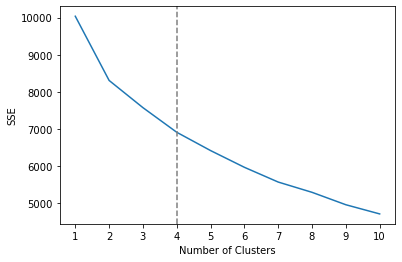

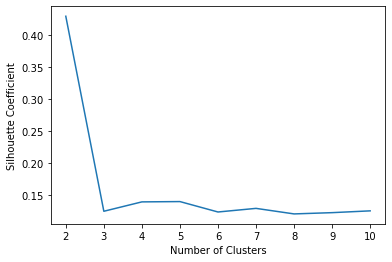

Ajusted Rand Index:
 0.06


In [15]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Diversidade Partidária",
    "Transporte Público",

    "Acesso à cultura, esporte e lazer",
    "Gravidez na infância e adolescência",
    "Trabalho Infantil",
    "Vulnerabilidade familiar",
    
    "Violência contra indígenas",
    "Violência contra indígenas Taxa",
    "Violência contra mulheres",
    "Violência infantil",
    "Violência infantil Taxa",

    "Empregos ensino superior",
    "Mulheres com empregos ensino superior"
]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)